# Homework 5
Eric Gagliano (egagli)

## Problem 1: Linear and Quantile Regression

USGS gaged streamflow records for the Columbia River at The Dalles, OR began in water year 1879 and continues to the present day (one of the longest continuous records in the U.S.). Peak flow records extend back to 1858 (based on peak stage values recorded by railroad workers). Using the coincident peak flow records from 1879-1933 (also a period with no major storage dams on the Columbia), create models to predict annual flow for years 1858-1878:

### A. Isolate the period of relevant overlap (1879-1933) and plot the timeseries. Create a linear regression model for annual flow using peak flow as an explanatory variable.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# read in data file
dalles_flow_file = 'dalles_flow.csv'
dalles_flow_full = pd.read_csv(dalles_flow_file,skiprows=2)
dalles_flow = dalles_flow_full[dalles_flow_full['Year'].between(1879,1933)]

In [3]:
# use the linear regression function
slope, intercept, rvalue, pvalue, stderr = stats.linregress(dalles_flow['Peak Daily (cfs)'],dalles_flow['Annual Mean (cfs)'])
x = np.linspace(dalles_flow['Peak Daily (cfs)'].min(), dalles_flow['Peak Daily (cfs)'].max(), 2) # make two x coordinates from min and max values of SLI_max
y = slope * x + intercept # y coordinates using the slope and intercept from our linear regression to draw a regression line

In [4]:
# print out the linear regression outputs
print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))
print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 92295.1358
B1 : 0.1958
R^2 : 0.753
R : 0.868
stderr : 0.015


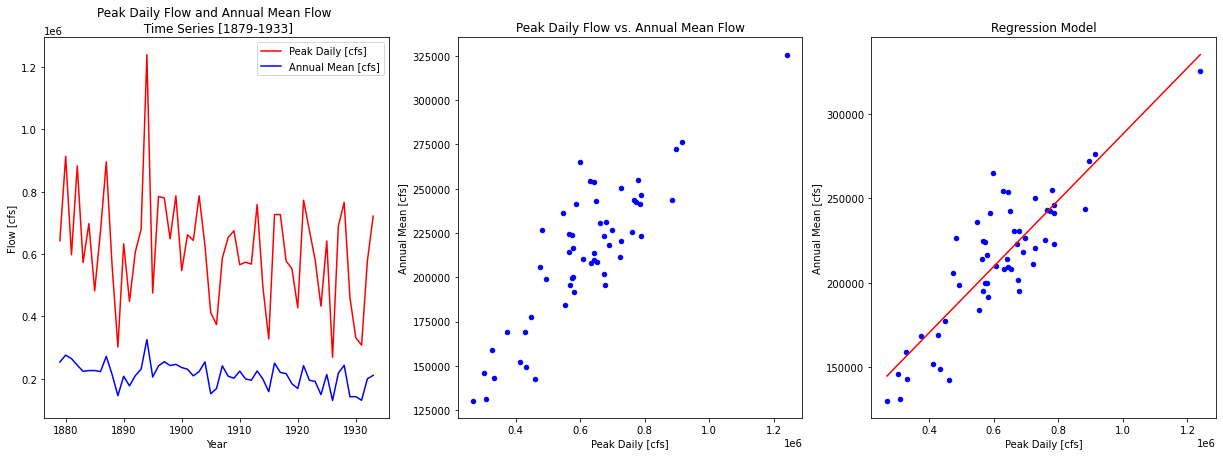

In [5]:
# plot flow time series, flow v flow, and regression model
fig, ax = plt.subplots(1,3,figsize=(21,7))

dalles_flow.plot(ax=ax[0],x='Year', y='Peak Daily (cfs)', c='r', label='Peak Daily [cfs]')
dalles_flow.plot(ax=ax[0],x='Year', y='Annual Mean (cfs)', c='b', label='Annual Mean [cfs]')
dalles_flow.plot.scatter(ax=ax[1],y='Annual Mean (cfs)', x='Peak Daily (cfs)', c='b')
dalles_flow.plot.scatter(ax=ax[2],y='Annual Mean (cfs)', x='Peak Daily (cfs)', c='b')

ax[2].plot(x, y, '-r')
ax[0].set_title('Peak Daily Flow and Annual Mean Flow \n Time Series [1879-1933]')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Flow [cfs]')
ax[1].set_title('Peak Daily Flow vs. Annual Mean Flow')
ax[1].set_ylabel('Annual Mean [cfs]')
ax[1].set_xlabel('Peak Daily [cfs]');
ax[2].set_title('Regression Model')
ax[2].set_ylabel('Annual Mean [cfs]')
ax[2].set_xlabel('Peak Daily [cfs]');

### B. How much of the variance is explained by the resulting model?

In [6]:
print(f'The R^2 value for the model is: {rvalue**2:.3}')

The R^2 value for the model is: 0.753


Based on our $R^2$ calculation from the linear regression model, approximately 75.3% of the variance in Peak Daily Flows is explained by the model.

### C. Estimate the 95% confidence intervals for the annual flow predictions from 1858-1878, and plot them with the central tendency (the central tendency is the prediction from the regression model).

In [7]:
# set x and y so we can use template code from the lab
x = dalles_flow['Peak Daily (cfs)']
y = dalles_flow['Annual Mean (cfs)']

In [8]:
# calculate errors, residuals, confidence intervals

n = len(x) # length of the original dataset
dof = n - 2 # degrees of freedom

B1, B0, r, p, sB1 = stats.linregress(x,y)

y_predicted = B0 + B1*x
residuals = (y - y_predicted)
# sum of squared errors
sse = np.sum(residuals**2)

# total sum of squares (y)
sst = np.sum( (y - np.mean(y))**2 )

# total sum of squares (x)
sst_x = np.sum( (x - np.mean(x))**2 )

# correlation coefficient
r_squared = 1 - sse/sst
r = np.sqrt( r_squared )

# standard error of regression
s = np.sqrt(sse/(n-2))

# our alpha for 95% confidence
alpha = 0.05

# t-value for alpha/2 with n-2 degrees of freedom
t = stats.t.ppf(1-alpha/2, dof)

# compute the upper and lower limits on our B1 (slope) parameter
B1_upper = B1 + t * sB1
B1_lower = B1 - t * sB1

# compute the corresponding upper and lower B0 values (y intercepts)
B0_upper = y.mean() - B1_upper*x.mean()
B0_lower = y.mean() - B1_lower*x.mean()

In [9]:
# predictions and confidence intervals on prediction
# an array of x values
p_x = np.linspace(x.min(),x.max(),55)

# using our model parameters to predict y values
p_y = B0 + B1*p_x

# calculate the standard error of the predictions
sigma_ep = np.sqrt( s**2 * (1 + 1/n + ( ( n*(p_x-x.mean())**2 ) / ( n*np.sum(x**2) - np.sum(x)**2 ) ) ) )

# our chosen alpha
alpha = 0.05

# compute our degrees of freedom with the length of the predicted dataset
n = len(p_x)
dof = n - 2

# get the t-value for our alpha and degrees of freedom
t = stats.t.ppf(1-alpha/2, dof)

# compute the upper and lower limits at each of the p_x values
p_y_lower = p_y - t * sigma_ep
p_y_upper = p_y + t * sigma_ep

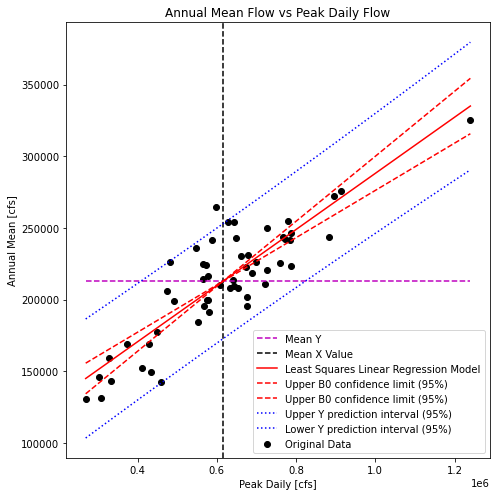

In [10]:
# plot prediction interval
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7), tight_layout=True)

# Scatterplot of original data
ax.scatter(x, y, c='k', label='Original Data')

# Plot the mean line, we only need two points to define a line, use xmin and xmax
ax.plot([x.min(), x.max()], [y.mean(), y.mean()] , '--m', label='Mean Y')

# Plot the mean x line
plt.axvline(x.mean(),c='k', linestyle='--', label='Mean X Value')

# Plot the linear regression model
ax.plot([x.min(), x.max()], [B0 + B1*x.min(), B0 + B1*x.max()], '-r', label='Least Squares Linear Regression Model')

# Plot the upper and lower confidence limits for the standard error of the gradient (slope)
ax.plot([x.min(), x.max()], [B0_upper + B1_upper*x.min(), B0_upper + B1_upper*x.max()] , '--r', label='Upper B0 confidence limit (95%)')
ax.plot([x.min(), x.max()], [B0_lower + B1_lower*x.min(), B0_lower + B1_lower*x.max()] , '--r', label='Upper B0 confidence limit (95%)')

# Plot confidence limits on our predicted Y values
ax.plot(p_x, p_y_upper, ':b', label='Upper Y prediction interval (95%)')
ax.plot(p_x, p_y_lower, ':b', label='Lower Y prediction interval (95%)')

# Add legend
plt.legend(loc='lower right');

# Add axes labels and title
ax.set_title('Annual Mean Flow vs Peak Daily Flow')
ax.set_ylabel('Annual Mean [cfs]')
ax.set_xlabel('Peak Daily [cfs]');

In [11]:
# pull out predictions during prediction interval
annual_predicted = B0 + dalles_flow['Peak Daily (cfs)']*B1
dalles_predict = dalles_flow_full[dalles_flow_full['Year'].between(1858,1878)]
annual_predicted_1858 = B0 + dalles_predict['Peak Daily (cfs)']*B1 
x = dalles_predict['Peak Daily (cfs)']
p_x = dalles_predict['Year']

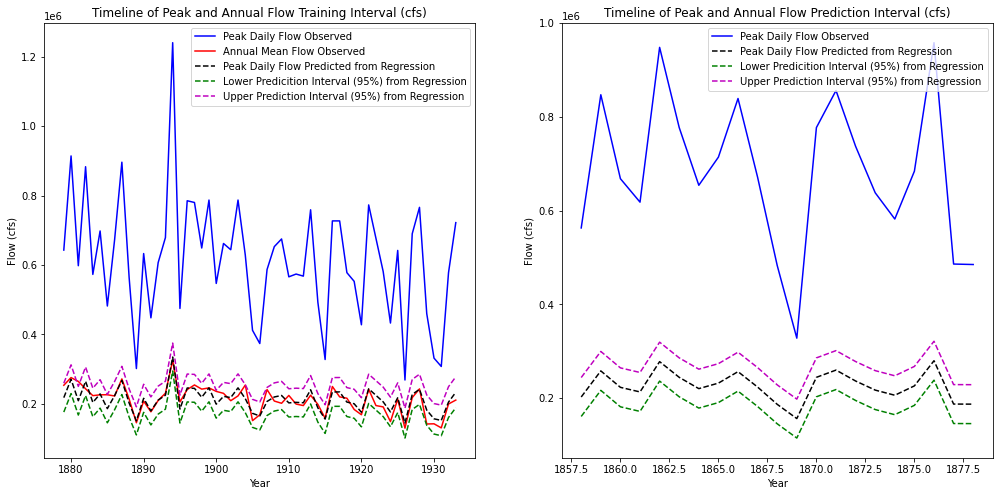

In [12]:
# plot predictions
# Original data:
f,ax=plt.subplots(1,2,figsize=(17,8))
ax[0].plot(dalles_flow['Year'],dalles_flow['Peak Daily (cfs)'],'b-', label='Peak Daily Flow Observed');
ax[0].plot(dalles_flow['Year'],dalles_flow['Annual Mean (cfs)'],'r-', label='Annual Mean Flow Observed');

# Predicted with linear regression between Slide Canyon and Blue Canyon
ax[0].plot(dalles_flow['Year'],annual_predicted,'k--', label='Peak Daily Flow Predicted from Regression')
ax[0].plot(dalles_flow['Year'],annual_predicted - t * sigma_ep,'g--', label='Lower Predicition Interval (95%) from Regression')
ax[0].plot(dalles_flow['Year'],annual_predicted + t*sigma_ep,'m--', label='Upper Prediction Interval (95%) from Regression')

ax[0].legend()
ax[0].set_title('Timeline of Peak and Annual Flow Training Interval (cfs)')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Flow (cfs)');

ax[1].set_title('Timeline of Peak and Annual Flow Prediction Interval (cfs)')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Flow (cfs)');

ax[1].plot(dalles_predict['Year'],dalles_predict['Peak Daily (cfs)'],'b-', label='Peak Daily Flow Observed');
#ax[1].plot(dalles_predict['Year'],dalles_predict['Annual Mean (cfs)'],'r-', label='Annual Mean Flow Observed');
sigma_ep = np.sqrt( s**2 * (1 + 1/n + ( ( n*(p_x-x.mean())**2 ) / ( n*np.sum(x**2) - np.sum(x)**2 ) ) ) )
ax[1].plot(dalles_predict['Year'],annual_predicted_1858,'k--', label='Peak Daily Flow Predicted from Regression')
ax[1].plot(dalles_predict['Year'],annual_predicted_1858 - t*sigma_ep,'g--', label='Lower Predicition Interval (95%) from Regression')
ax[1].plot(dalles_predict['Year'],annual_predicted_1858 + t*sigma_ep,'m--', label='Upper Prediction Interval (95%) from Regression')

ax[1].legend()

### D. Now create a non-parametric, quantile-based regression model using the same data.

In [13]:
# This function should be able to accept any one-dimensional numpy array or list, of numbers
# It returns two numpy arrays, one of the sorted numbers, the other of the plotting position
def cunnane_quantile_array(numbers):
    '''This function also computes the Cunnane plotting position given an array or list of numbers (rather than a pandas dataframe).
    It has two outputs, first the sorted numbers, second the Cunnane plotting position for each of those numbers.
    [Steven Pestana, spestana@uw.edu, Oct. 2020]'''
    
    # 1) sort the data, using the numpy sort function (np.sort())
    sorted_numbers = np.sort(numbers)
    
    # length of the list of numbers
    n = len(sorted_numbers) 
    
    # make an empty array, of the same length. below we will add the plotting position values to this array
    cunnane_plotting_position = np.empty(n)
    
    # 2) compute the Cunnane plotting position for each number, using a for loop and the enumerate function
    for rank, number in enumerate(sorted_numbers):
        cunnane_plotting_position[rank] = ( (rank+1) - (2/5) ) / ( n + (1/5) )
    
    return sorted_numbers, cunnane_plotting_position

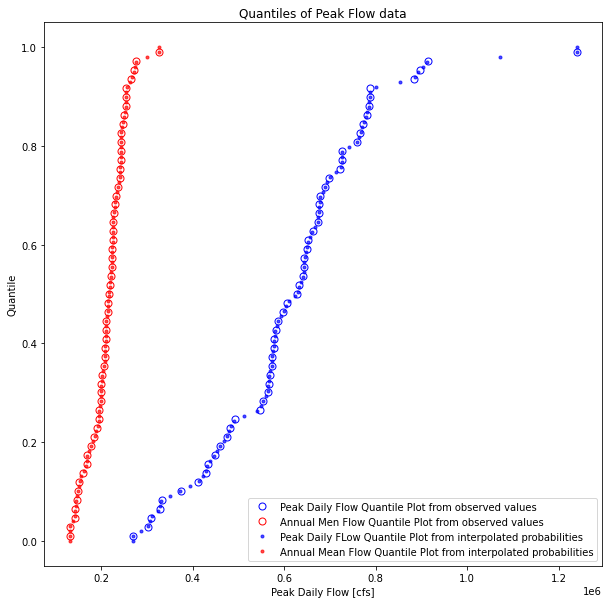

In [14]:
# quantile plots
plt.figure(figsize=(10,10))

# Here we use the actual values from the dataset to create the plots
PD_ordered, PD_quantile = cunnane_quantile_array(dalles_flow['Peak Daily (cfs)'])
AM_ordered, AM_quantile = cunnane_quantile_array(dalles_flow['Annual Mean (cfs)'])
plt.plot(PD_ordered, PD_quantile, 'o', markeredgecolor='b', markerfacecolor='None', markersize=7, label='Peak Daily Flow Quantile Plot from observed values')
plt.plot(AM_ordered, AM_quantile, 'o', markeredgecolor='r', markerfacecolor='None', markersize=7, label='Annual Men Flow Quantile Plot from observed values')


# We can also create these by picking arbitrary quantile values, then using the scipy.stats.mstats.mquantiles function
quantiles = np.linspace(0,1,100) # 100 quantile values linearly spaced between 0 and 1
plt.plot(stats.mstats.mquantiles(dalles_flow['Peak Daily (cfs)'], quantiles), quantiles, 
         'b.', label='Peak Daily FLow Quantile Plot from interpolated probabilities', alpha=0.7)
plt.plot(stats.mstats.mquantiles(dalles_flow['Annual Mean (cfs)'], quantiles), quantiles, 
         'r.', label='Annual Mean Flow Quantile Plot from interpolated probabilities', alpha=0.7)

plt.ylabel('Quantile')
plt.xlabel('Peak Daily Flow [cfs]')
#plt.xlim((0,2500))
#plt.ylim((0,1))
plt.title('Quantiles of Peak Flow data')
plt.legend(loc="best");

In [15]:
# creatq quantiles
quantiles = np.linspace(0,1,100)

# This is our empirical cdf of the Slide Canyon data, which also includes values down to 0 and up to 1.
PD_ordered = stats.mstats.mquantiles(dalles_flow['Annual Mean (cfs)'], quantiles)

# This is our empirical cdf of the Blue Canyon data, which also includes values down to 0 and up to 1.
AM_ordered = stats.mstats.mquantiles(dalles_flow['Peak Daily (cfs)'], quantiles)

In [16]:
# Create our interpolation function for looking up a quantile given a value of SWE at Slide Canyon
f_AM = interp1d(AM_ordered, quantiles)
# Create our interpolation function for looking up SWE at Blue Canyon given a quantile
g_PD = interp1d(quantiles, PD_ordered)

# Now, we can create a prediction for every value in the Slide Canyon dataset to come up with a matching prediction for the Blue Canyon dataset
PD_predicted=g_PD( f_AM( dalles_flow['Peak Daily (cfs)'] ) )

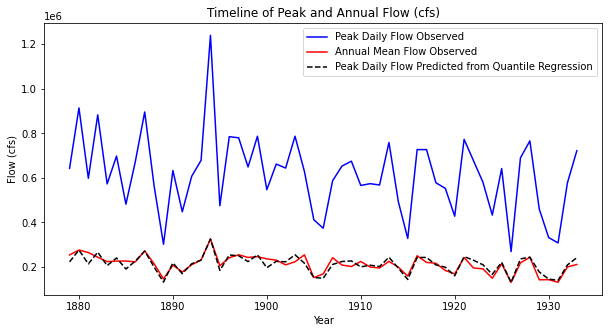

In [17]:
# And we can see how well this did by making a time series plot of our actual and predicted values
# Original data:
plt.figure(figsize=(10,5))
plt.plot(dalles_flow['Year'],dalles_flow['Peak Daily (cfs)'],'b-', label='Peak Daily Flow Observed');
plt.plot(dalles_flow['Year'],dalles_flow['Annual Mean (cfs)'],'r-', label='Annual Mean Flow Observed');

# Predicted with linear regression between Slide Canyon and Blue Canyon
plt.plot(dalles_flow['Year'],PD_predicted,'k--', label='Peak Daily Flow Predicted from Quantile Regression')
plt.legend()
plt.title('Timeline of Peak and Annual Flow (cfs)')
plt.xlabel('Year')
plt.ylabel('Flow (cfs)');


### E. Plot the predictions and residuals for the two different prediction models for the training period (1879-1933), and plot the model predictions for the 1858-1878 data for the two different models. Is there a substantial difference between the two model formulations? Discuss any differences that you observe.

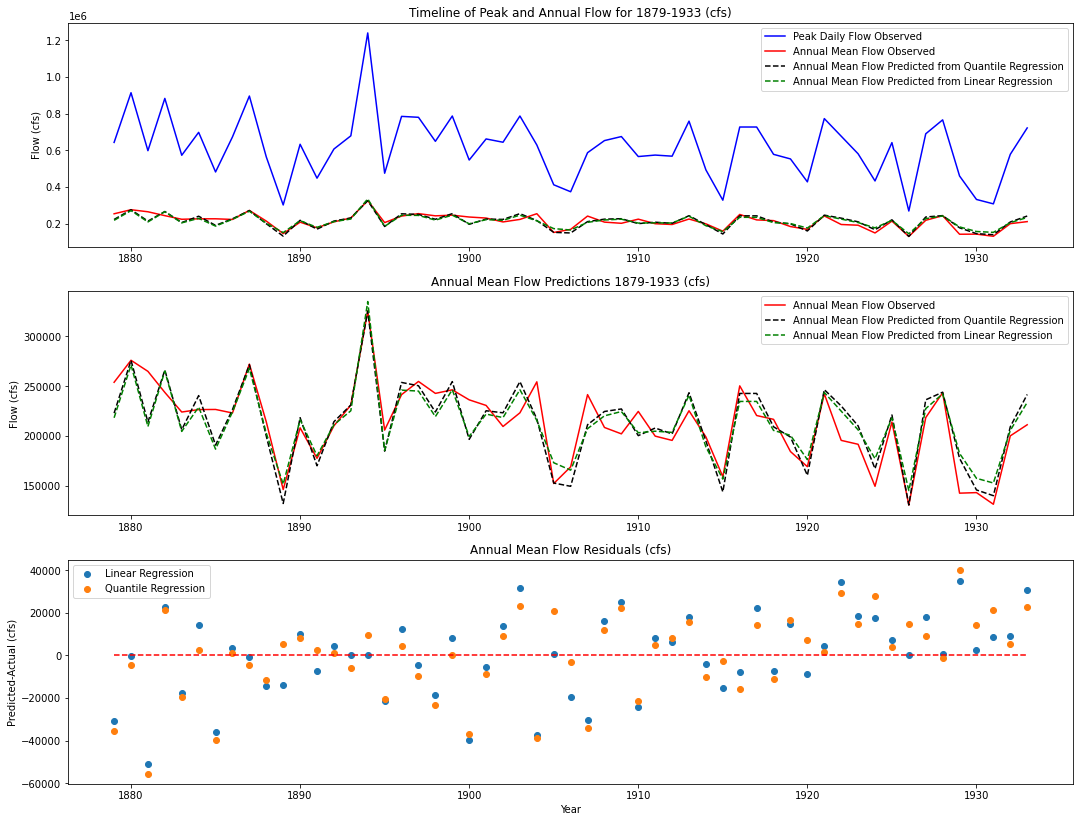

In [18]:
# And we can see how well this did by making a time series plot of our actual and predicted values
# Original data:
f,ax=plt.subplots(3,1,figsize=(18,14))
ax[0].plot(dalles_flow['Year'],dalles_flow['Peak Daily (cfs)'],'b-', label='Peak Daily Flow Observed');
ax[0].plot(dalles_flow['Year'],dalles_flow['Annual Mean (cfs)'],'r-', label='Annual Mean Flow Observed');

ax[0].plot(dalles_flow['Year'],PD_predicted,'k--', label='Annual Mean Flow Predicted from Quantile Regression')
ax[0].plot(dalles_flow['Year'],annual_predicted,'g--', label='Annual Mean Flow Predicted from Linear Regression')

ax[0].legend()
ax[0].set_title('Timeline of Peak and Annual Flow for 1879-1933 (cfs)')
ax[0].set_ylabel('Flow (cfs)');

ax[1].plot(dalles_flow['Year'],dalles_flow['Annual Mean (cfs)'],'r-', label='Annual Mean Flow Observed');
ax[1].plot(dalles_flow['Year'],PD_predicted,'k--', label='Annual Mean Flow Predicted from Quantile Regression')
ax[1].plot(dalles_flow['Year'],annual_predicted,'g--', label='Annual Mean Flow Predicted from Linear Regression')

ax[1].legend()
ax[1].set_title('Annual Mean Flow Predictions 1879-1933 (cfs)')
ax[1].set_ylabel('Flow (cfs)');

ax[2].scatter(dalles_flow['Year'],PD_predicted-dalles_flow['Annual Mean (cfs)'],label='Linear Regression')
ax[2].scatter(dalles_flow['Year'],annual_predicted-dalles_flow['Annual Mean (cfs)'],label='Quantile Regression')
ax[2].legend()
ax[2].set_title('Annual Mean Flow Residuals (cfs)')
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Predicted-Actual (cfs)');
ax[2].hlines(0,dalles_flow['Year'].min(),dalles_flow['Year'].max(),linestyles='dashed',color='r')

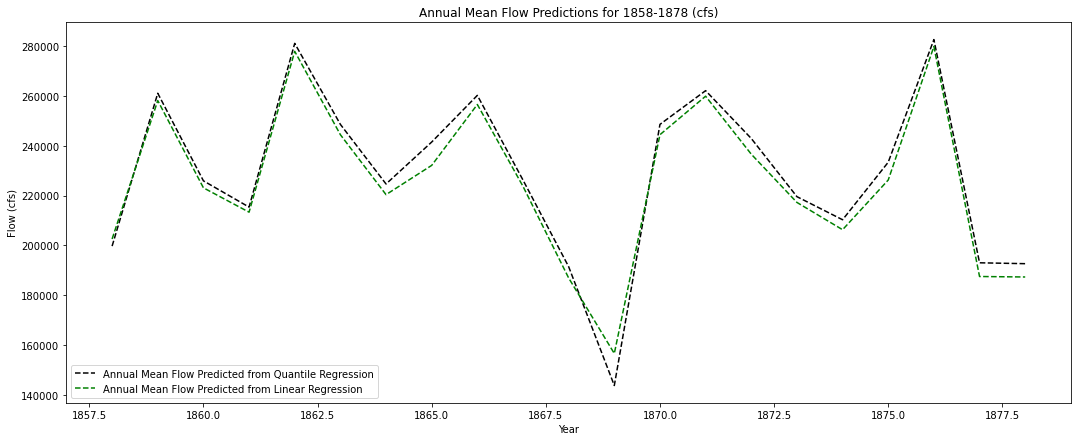

In [19]:
f,ax=plt.subplots(figsize=(18,7))
PD_predicted=g_PD( f_AM( dalles_predict['Peak Daily (cfs)'] ) )
ax.plot(dalles_predict['Year'],PD_predicted,'k--', label='Annual Mean Flow Predicted from Quantile Regression')
ax.plot(dalles_predict['Year'],annual_predicted_1858,'g--', label='Annual Mean Flow Predicted from Linear Regression')
ax.legend()
ax.set_title('Annual Mean Flow Predictions for 1858-1878 (cfs)')
ax.set_xlabel('Year')
ax.set_ylabel('Flow (cfs)');

Though higly correlated, there is a small difference between the two prediction methods. We notice that as the absolute value of flow increases, the difference between the two methods decreases. Because the differences in predictions is so small, I would guess that the assumptions for linear regression were probably were probably met / close to being met as the underlying distribution was likely approximately normal.

## Problem 2: Trend Analysis

The first column is the water year, and data in the next three columns are values for total precipitation (mm), daily maximum temperature (°C), and daily minimum temperature (°C) averaged from October-March over the Pacific Northwest Cascades in Washington and Oregon. The last column is an estimate of April 1st snow water equivalent (in mm, the water content of the snowpack on this day) from model simulations, averaged over the same domain.

### A. Calculate the long-term trend in April 1 SWE from 1916-2003 by fitting a linear model to the data. Estimate the uncertainty in the trend by evaluating a 95% confidence interval around the estimate of B1. That is, report the trend as: Trend = B1 ± t*sB1

In [20]:
# import cascades data and view
cascades_swe_file = 'cascades_swe.xlsx'
cascades_swe = pd.read_excel(cascades_swe_file,skiprows=8,usecols=[1,2,3,4,5])
cascades_swe

,Water Year,oct-mar precip,oct-mar tmax,oct-mar tmin,April 1 SWE
0,1916,1154.570,5.03776,-5.06206,393.719
1,1917,820.952,4.56727,-6.50644,377.514
2,1918,1095.650,7.86584,-3.23471,310.131
3,1919,1041.050,5.80953,-4.22977,287.759
4,1920,817.106,5.14475,-5.36376,237.118
...,...,...,...,...,...
83,1999,1349.600,6.09335,-3.16271,440.455
84,2000,1071.650,6.92193,-2.91330,321.225
85,2001,585.318,6.24188,-3.64529,124.212
86,2002,1111.340,6.29529,-2.79578,358.346


In [21]:
# define x and y so we can use template code from labs
x = cascades_swe['Water Year']
y = cascades_swe['April 1 SWE']

In [22]:
# compute errors, residuals, confidence intervals
# length of the original dataset
n = len(x)
# degrees of freedom
dof = n - 2

B1, B0, r, p, sB1 = stats.linregress(x,y)

y_predicted = B0 + B1*x
residuals = (y - y_predicted)
# sum of squared errors
sse = np.sum(residuals**2)

# total sum of squares (y)
sst = np.sum( (y - np.mean(y))**2 )

# total sum of squares (x)
sst_x = np.sum( (x - np.mean(x))**2 )

# correlation coefficient
r_squared = 1 - sse/sst
r = np.sqrt( r_squared )

# standard error of regression
s = np.sqrt(sse/(n-2))

# our alpha for 95% confidence
alpha = 0.05

# t-value for alpha/2 with n-2 degrees of freedom
t = stats.t.ppf(1-alpha/2, dof)

# compute the upper and lower limits on our B1 (slope) parameter
B1_upper = B1 + t * sB1
B1_lower = B1 - t * sB1

# compute the corresponding upper and lower B0 values (y intercepts)
B0_upper = y.mean() - B1_upper*x.mean()
B0_lower = y.mean() - B1_lower*x.mean()

In [23]:
# prediction intervals
# an array of x values
p_x = np.linspace(x.min(),x.max(),100)

# using our model parameters to predict y values
p_y = B0 + B1*p_x

# calculate the standard error of the predictions
sigma_ep = np.sqrt( s**2 * (1 + 1/n + ( ( n*(p_x-x.mean())**2 ) / ( n*np.sum(x**2) - np.sum(x)**2 ) ) ) )

# our chosen alpha
alpha = 0.05

# compute our degrees of freedom with the length of the predicted dataset
n = len(p_x)
dof = n - 2

# get the t-value for our alpha and degrees of freedom
t = stats.t.ppf(1-alpha/2, dof)

# compute the upper and lower limits at each of the p_x values
p_y_lower = p_y - t * sigma_ep
p_y_upper = p_y + t * sigma_ep

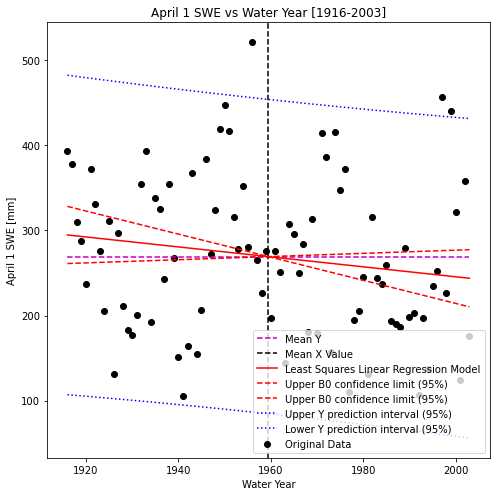

In [24]:
# plot confidence and prediction intervals
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7), tight_layout=True)

# Scatterplot of original data
ax.scatter(x, y, c='k', label='Original Data')

# Plot the mean line, we only need two points to define a line, use xmin and xmax
ax.plot([x.min(), x.max()], [y.mean(), y.mean()] , '--m', label='Mean Y')

# Plot the mean x line
plt.axvline(x.mean(),c='k', linestyle='--', label='Mean X Value')

# Plot the linear regression model
ax.plot([x.min(), x.max()], [B0 + B1*x.min(), B0 + B1*x.max()], '-r', label='Least Squares Linear Regression Model')

# Plot the upper and lower confidence limits for the standard error of the gradient (slope)
ax.plot([x.min(), x.max()], [B0_upper + B1_upper*x.min(), B0_upper + B1_upper*x.max()] , '--r', label='Upper B0 confidence limit (95%)')
ax.plot([x.min(), x.max()], [B0_lower + B1_lower*x.min(), B0_lower + B1_lower*x.max()] , '--r', label='Upper B0 confidence limit (95%)')

# Plot confidence limits on our predicted Y values
ax.plot(p_x, p_y_upper, ':b', label='Upper Y prediction interval (95%)')
ax.plot(p_x, p_y_lower, ':b', label='Lower Y prediction interval (95%)')

# Add legend
plt.legend(loc='lower right');

# Add axes labels and title
ax.set_xlabel('Water Year')
ax.set_ylabel('April 1 SWE [mm]')
ax.set_title('April 1 SWE vs Water Year [1916-2003]');

In [25]:
# print regression outputs
print(f'Lower bound of 95% confidence interval for slope: B1 - t*sB1 = {B1_lower:.3}')
print(f'Average slope: B1 = {B1:.3}')
print(f'Lower bound of 95% confidence interval for slope: B1 + t*sB1 = {B1_upper:.3}')
print(f'The p-value is: {p:.3}')

Lower bound of 95% confidence interval for slope: B1 - t*sB1 = -1.36
Average slope: B1 = -0.585
Lower bound of 95% confidence interval for slope: B1 + t*sB1 = 0.187
The p-value is: 0.136


### B. Is the trend statistically significant with 95% confidence? Can we reject the null hypothesis that the trend is equal to zero?

No, this trend is not statistically significant with 95% confidence, because the 95% confidence interval contains the slope of 0. Therefore, we fail to reject the null hypothesis that there is not a trend in this data. Our p-value of 0.136 confirms this, as this is less than our alpha of 0.05.

### C. Repeat this analysis (parts A and B) for just the more recent period, 1976-2003. Discuss any similarities or differences in the results of the two time periods.

In [26]:
# redefine x and y so we can use template code from labs
x = cascades_swe[cascades_swe['Water Year'].between(1976,2003)]['Water Year']
y = cascades_swe[cascades_swe['Water Year'].between(1976,2003)]['April 1 SWE']

In [27]:
# compute errors, resifuals, confidence intervals
# length of the original dataset
n = len(x)
# degrees of freedom
dof = n - 2

B1, B0, r, p, sB1 = stats.linregress(x,y)

y_predicted = B0 + B1*x
residuals = (y - y_predicted)
# sum of squared errors
sse = np.sum(residuals**2)

# total sum of squares (y)
sst = np.sum( (y - np.mean(y))**2 )

# total sum of squares (x)
sst_x = np.sum( (x - np.mean(x))**2 )

# correlation coefficient
r_squared = 1 - sse/sst
r = np.sqrt( r_squared )

# standard error of regression
s = np.sqrt(sse/(n-2))

# our alpha for 95% confidence
alpha = 0.05

# t-value for alpha/2 with n-2 degrees of freedom
t = stats.t.ppf(1-alpha/2, dof)

# compute the upper and lower limits on our B1 (slope) parameter
B1_upper = B1 + t * sB1
B1_lower = B1 - t * sB1

# compute the corresponding upper and lower B0 values (y intercepts)
B0_upper = y.mean() - B1_upper*x.mean()
B0_lower = y.mean() - B1_lower*x.mean()

In [28]:
# prediction intervals # an array of x values
p_x = np.linspace(x.min(),x.max(),100)

# using our model parameters to predict y values
p_y = B0 + B1*p_x

# calculate the standard error of the predictions
sigma_ep = np.sqrt( s**2 * (1 + 1/n + ( ( n*(p_x-x.mean())**2 ) / ( n*np.sum(x**2) - np.sum(x)**2 ) ) ) )

# our chosen alpha
alpha = 0.05

# compute our degrees of freedom with the length of the predicted dataset
n = len(p_x)
dof = n - 2

# get the t-value for our alpha and degrees of freedom
t = stats.t.ppf(1-alpha/2, dof)

# compute the upper and lower limits at each of the p_x values
p_y_lower = p_y - t * sigma_ep
p_y_upper = p_y + t * sigma_ep

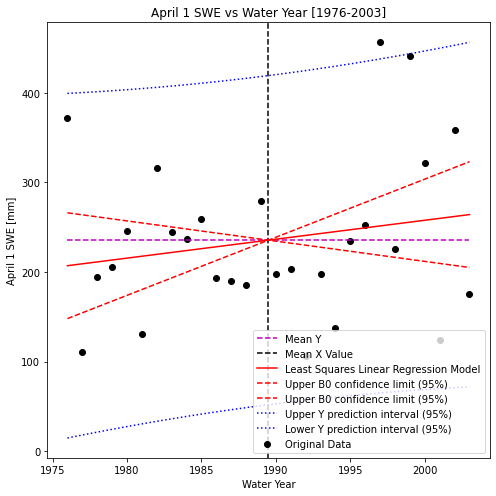

In [29]:
# plot prediction intervals
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7), tight_layout=True)

# Scatterplot of original data
ax.scatter(x, y, c='k', label='Original Data')

# Plot the mean line, we only need two points to define a line, use xmin and xmax
ax.plot([x.min(), x.max()], [y.mean(), y.mean()] , '--m', label='Mean Y')

# Plot the mean x line
plt.axvline(x.mean(),c='k', linestyle='--', label='Mean X Value')

# Plot the linear regression model
ax.plot([x.min(), x.max()], [B0 + B1*x.min(), B0 + B1*x.max()], '-r', label='Least Squares Linear Regression Model')

# Plot the upper and lower confidence limits for the standard error of the gradient (slope)
ax.plot([x.min(), x.max()], [B0_upper + B1_upper*x.min(), B0_upper + B1_upper*x.max()] , '--r', label='Upper B0 confidence limit (95%)')
ax.plot([x.min(), x.max()], [B0_lower + B1_lower*x.min(), B0_lower + B1_lower*x.max()] , '--r', label='Upper B0 confidence limit (95%)')

# Plot confidence limits on our predicted Y values
ax.plot(p_x, p_y_upper, ':b', label='Upper Y prediction interval (95%)')
ax.plot(p_x, p_y_lower, ':b', label='Lower Y prediction interval (95%)')

# Add legend
plt.legend(loc='lower right');

# Add axes labels and title
ax.set_xlabel('Water Year')
ax.set_ylabel('April 1 SWE [mm]')
ax.set_title('April 1 SWE vs Water Year [1976-2003]');

In [30]:
# print regressgion coeffs
print(f'Lower bound of 95% confidence interval for slope: B1 - t*sB1 = {B1_lower:.3}')
print(f'Average slope: B1 = {B1:.3}')
print(f'Lower bound of 95% confidence interval for slope: B1 + t*sB1 = {B1_upper:.3}')
print(f'The p-value is: {p:.3}')

Lower bound of 95% confidence interval for slope: B1 - t*sB1 = -2.26
Average slope: B1 = 2.11
Lower bound of 95% confidence interval for slope: B1 + t*sB1 = 6.49
The p-value is: 0.33


Here, we still fail to reject the null hypotheis at the 95% confidence level that there is no trend in this data because our 95% confidence interval still contains the slope of 0. We confirm this because the p value of 0.33 here is even larger than in the last calculation, and it is still less than our alpha of 0.05. 

## Problem 3: The best graphics

One of our greatest challenges in data analysis is to be able to visualize the information in the data and convey that information to others. Consider various scientific papers you have read (on any subject related to your scientific/engineering discipline) and pick out your favorite graphical representation of data (e.g., the best figure). Include your top two choices in your homework submission with a brief statement of why you chose these figures. We'll share some of these favorite figures in class.

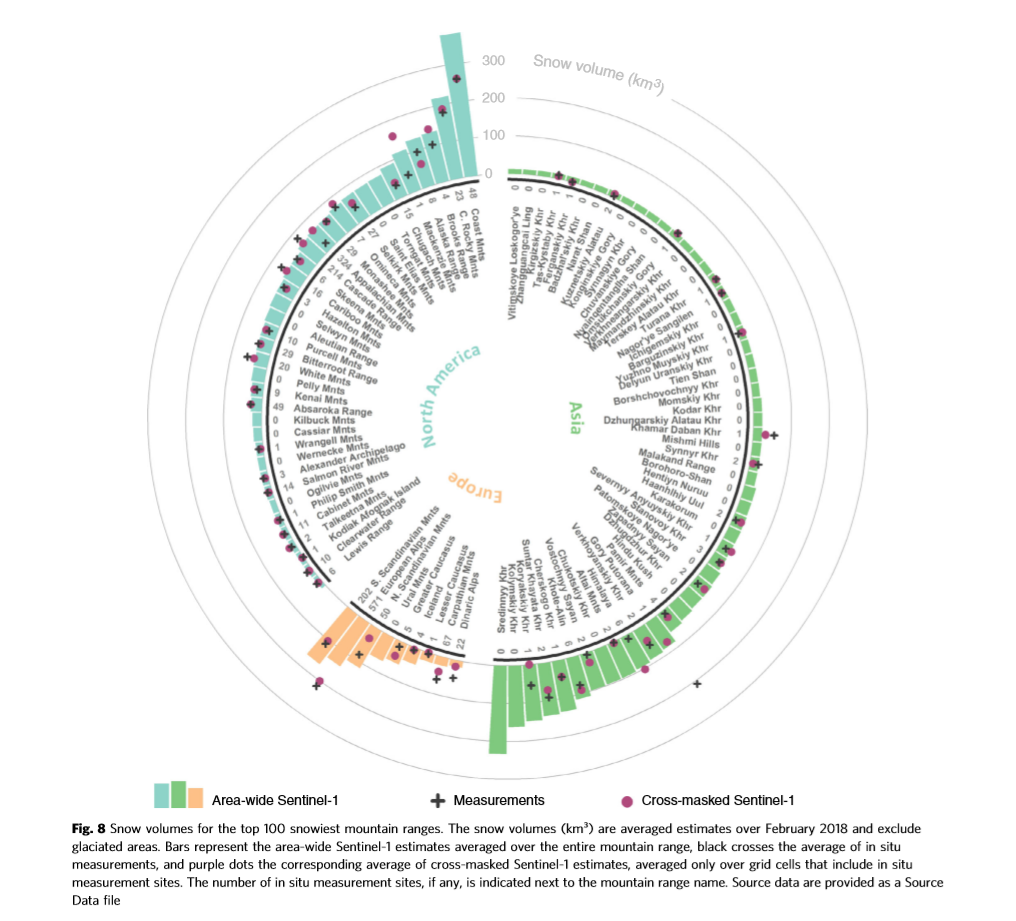

**Lievens et al. 2019 "Snow depth variability in the Northern Hemisphere mountains observed from space"**: I chose this graphic because I love the unique display of information. It is very readable and its format lends itself well to convey a lot of information in an unobtrusive way. For instance, the radial layout allows grouping of mountain ranges by region that would be too cluttered in an upright layout, and it also allows easy relative comparisons of snow volume with accompanying validation data.

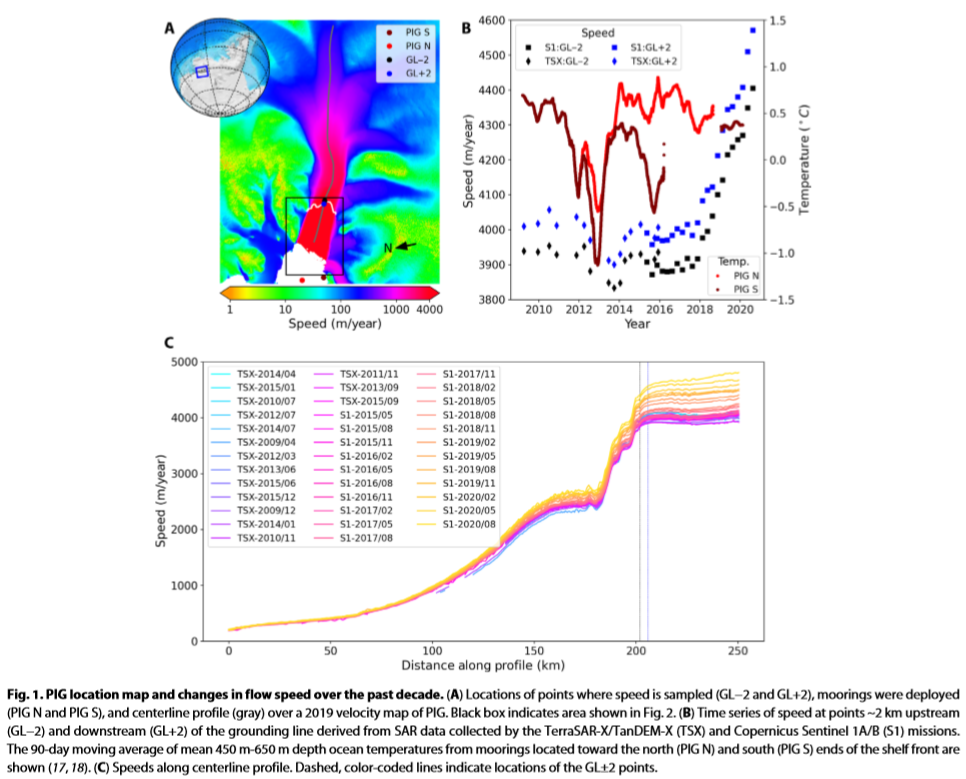

**Joughin et al. 2021 "Ice-shelf retreat drives recent Pine Island Glacier speedup"**: I chose this graphic because of the lovely contextual information of panel A which enriches panels B and C, the lovely colors, and the ingenious communication of large ammounts of various types of data in concise and easy to read graphs.

## Problem 4: CEWA 565 Revised Proposal

Seth Vanderwilt and I will use Sentinel-1 Synthetic Aperture Radar (SAR) backscatter time series to explore snow melt dynamics over Mt. Rainier. We hope to focus on snow melt timings and how they differ based on aspect and elevation. These null hypotheses will be snow melt timing is not affected by (aspect, elevation). The alternate hyoptheses will be snow melt timing is affected by (aspect, elevation). We might also explore how snow melt timing may have differed over Mt. Rainier from this past year compared to previous years because we know it experienced a quite extreme melt season this year, as well as the fact that other groups will also be looking at Mt. Rainier allowing for some interco"mparison. Because our SAR time series is limited to the years Sentinel-1 was/is collecting data, we will have to suplement our data somehow if we want to explore this problem. We might also look how Mt. Rainier melt timings may be different from melt timings of other mountains in the Cascades. We will use a statistical test for significance: our null hypothesis is that snow melt timing (and aspect/elevation) does not differ between mountains, and the alternate hyopthesis is that snow melt timing (and aspect/elevation) does differ between mountains.

# References

Note: A large amount of this code is adapted from the CEWA 565 course materials, predominantly from the lab 3 jupyter notebook which can be found in module 3 of the class website: https://mountain-hydrology-research-group.github.io/data-analysis/modules/module3.html